In [1]:
!pip install numpy opencv-python albumentations torch torchvision
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/


 best_model_state.bin   city_scapes  'Colab Notebooks'	 siüüüü


In [5]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [6]:
dataset = Cityscapes('/content/drive/MyDrive/city_scapes', split='train', mode='fine',
                      target_type='semantic')

In [7]:
dataset[0][0].size

(2048, 1024)

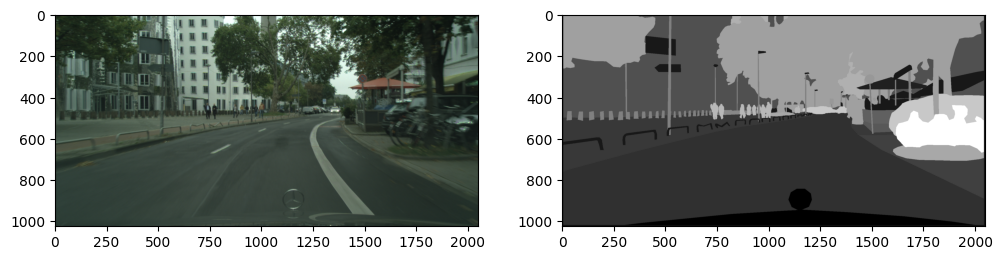

In [8]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

In [9]:
ignore_index = 255


void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]


valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]


class_names = [
    'unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'sky',
    'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle'
]

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [10]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [11]:
def encode_segmap(mask):

    for _voidc in void_classes:

        mask[mask == _voidc] = ignore_index

    for _validc in valid_classes:

        if _validc in class_map:
            mask[mask == _validc] = class_map[_validc]

    return mask


In [12]:
import numpy as np

def decode_segmap(temp):

    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]


    rgb = np.zeros((temp.shape[0], temp.shape[1], 3), dtype=np.float32)
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)

In [15]:
dataset=MyClass('/content/drive/MyDrive/city_scapes', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


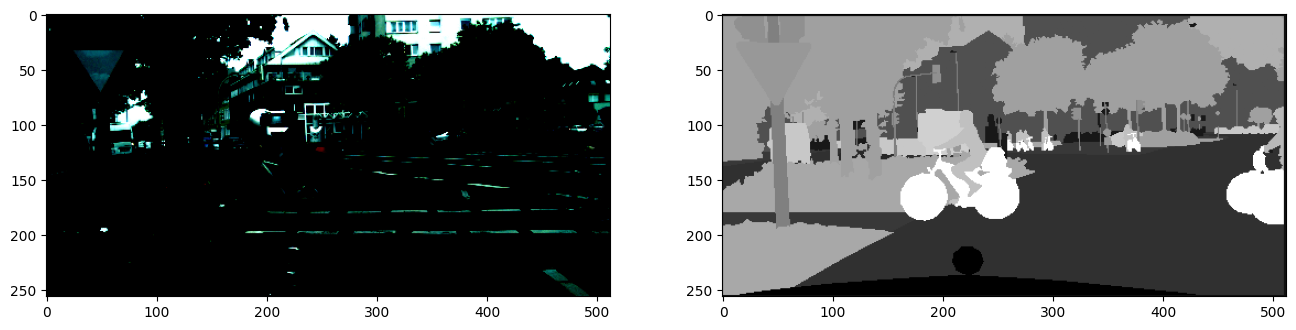

In [16]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [17]:
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  6,  7,  8, 11, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33],
       dtype=torch.uint8)
18


In [18]:

res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19],
       dtype=torch.uint8)
15


In [19]:
res1=decode_segmap(res.clone())

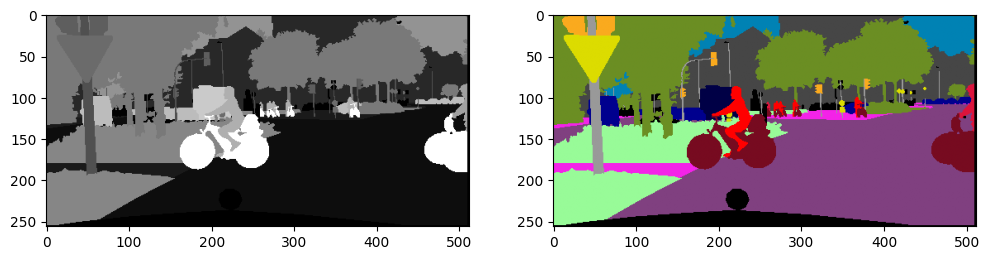

In [20]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

In [21]:
! nvidia-smi

Sat Oct  5 13:54:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
! pip3 install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=41bdbcc823bcefda68586b77d708dcd88f1894c75480b028fd6becf6cba1a8df
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=db1b06c5c642134013e58e910cd8dfc5f0d50f4d883cd5127764cacf0dfb7b3e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [25]:
!pip install pytorch_lightning
!pip install segmentation-models-pytorch

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 56.0 MB/s eta 0:00:00


In [29]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name="resnet34",
                encoder_weights="imagenet",
                in_channels=3,
                classes=n_classes,
            )


    self.lr=1e-3
    self.batch_size=32
    self.numworker=multiprocessing.cpu_count()//4

    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(task='multiclass', num_classes=n_classes)

    self.train_class = MyClass('/content/drive/MyDrive/city_scapes', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
    self.val_class = MyClass('/content/drive/MyDrive/city_scapes', split='val', mode='fine',
                     target_type='semantic',transforms=transform)


  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    iou=self.metrics(out,segment)
    return loss,iou

  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
    self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size,
                      shuffle=False,num_workers=self.numworker,pin_memory=True)

  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [30]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)



In [32]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=50,
    accelerator='gpu',
    devices="auto",
    precision=16,
    callbacks=[checkpoint_callback],
)


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model)
torch.save(model.state_dict(), 'model.pth')

NameError: name 'trainer' is not defined